## Walmart sales - autoregressive models

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from plotnine import *

from IPython.display import display
from tqdm import tqdm_notebook as tqdm

from datetime import datetime, timedelta

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("whitegrid")

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

### Dataframes

In [3]:
df = pd.read_csv('data/processed/all.csv')

df['Date'] = pd.to_datetime(df['Date'])

holidays = sorted(df.query('IsHoliday==True').DateString.unique())
stores = sorted(df.Store.unique())

Building dataframes for a single store, which will be useful to study the data

In [4]:
df1 = df.copy().query("Store==1 and Train")
df1_idx = df1.set_index(['Date'])
df1_sales = df1_idx['WeeklySales']

### SARIMAX

#### Grid search for p,d,q,s

We'll search all combinations of the following parameters for the order:

* p: 0 to 4
* d: 0 to 2
* q: 0 to 4

We'll search all combinations of the following parameters for the seasonal order:

* p: 0 to 2
* d: 0 to 2
* q: 0 to 2
* s: 52 (yearly)

We'll use the first store for evaluating the best parameters

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

# many convergency warnings are expected, so let's disable warnings
import warnings
warnings.filterwarnings('ignore')

# ((p,d,q), metric)
best_rmse, best_wmae, best_mae = None, None, None

for pdq_pdqs in tqdm(list(product(range(5), range(3), range(5), range(2), range(2), range(2), [52]))):
    
    pdq = (pdq_pdqs[0], pdq_pdqs[1], pdq_pdqs[2])
    pdqs = (pdq_pdqs[3], pdq_pdqs[4], pdq_pdqs[5], pdq_pdqs[6])
    
    try:
        model = SARIMAX(df1_sales, order=pdq, enforce_stationarity=False, enforce_invertibility=False, seasonal_order=pdqs)
        fit = model.fit(disp=0)
        y_actual = df1_idx.WeeklySales.values
        y_pred = fit.predict().values
        w = df1.IsHoliday.map(lambda v: 5 if v else 1).values
        
        rmse = np.sqrt(np.mean((y_pred-y_actual)**2))    
        wmae = np.sum(w*(y_pred-y_actual)) / np.sum(w)
        mae = np.mean(np.abs(y_pred-y_actual))

        if best_rmse==None or abs(best_rmse[2]) > abs(rmse):
            best_rmse = (pdq, pdqs, rmse)
        if best_wmae==None or abs(best_wmae[2]) > abs(wmae):
            best_wmae = (pdq, pdqs, wmae)
        if best_mae==None or abs(best_mae[2]) > abs(mae):
            best_mae = (pdq, pdqs, mae)         
    except:
        #print("not valid: %s %s" % (str(pdq), str(pdqs)))
        continue

# re-enable warnings
warnings.simplefilter('always')        
        
print("Best RMSE: %s %s %s" % best_rmse)
print("Best WMAE: %s %s %s" % best_wmae)
print("Best MAE: %s %s %s" % best_mae)


Best RMSE: (4, 1, 1) (1, 0, 0, 52) 2539.42102426
Best WMAE: (4, 1, 1) (1, 0, 0, 52) -0.110016272531
Best MAE: (2, 1, 3) (1, 0, 0, 52) 1180.36355324


In [6]:
dfa = df.copy()[['Date', 'WeeklySales', 'Store', 'IsHoliday']]
dfa['WeeklySalesForecast'] = np.nan

# many convergency warnings are expected, so let's disable warnings
import warnings
warnings.filterwarnings('ignore')

for store in tqdm(stores):
    
    # fit the model using past sales and perform in-sample forecasts
    idx = (df.Store==store) & (df.WeeklySales.notnull())
    X = dfa[idx].WeeklySales.values
    model = SARIMAX(X, order=best_wmae[0], enforce_stationarity=False, enforce_invertibility=False, seasonal_order=best_wmae[1])
    fit = model.fit(disp=0)
    dfa.loc[idx, 'WeeklySalesForecast'] = fit.predict()
    
    # calculate out-of-sample forecasts
    idx = (df.Store==store) & (df.WeeklySales.isnull())
    X = dfa[idx].WeeklySales.values
    steps = len(dfa[idx])
    y_pred = fit.get_forecast(steps=39).predicted_mean
    dfa.loc[idx, 'WeeklySalesForecast'] = y_pred
    
# re-enable warnings
warnings.simplefilter('always')     

dfa['Residuals'] = dfa.WeeklySales - dfa.WeeklySalesForecast

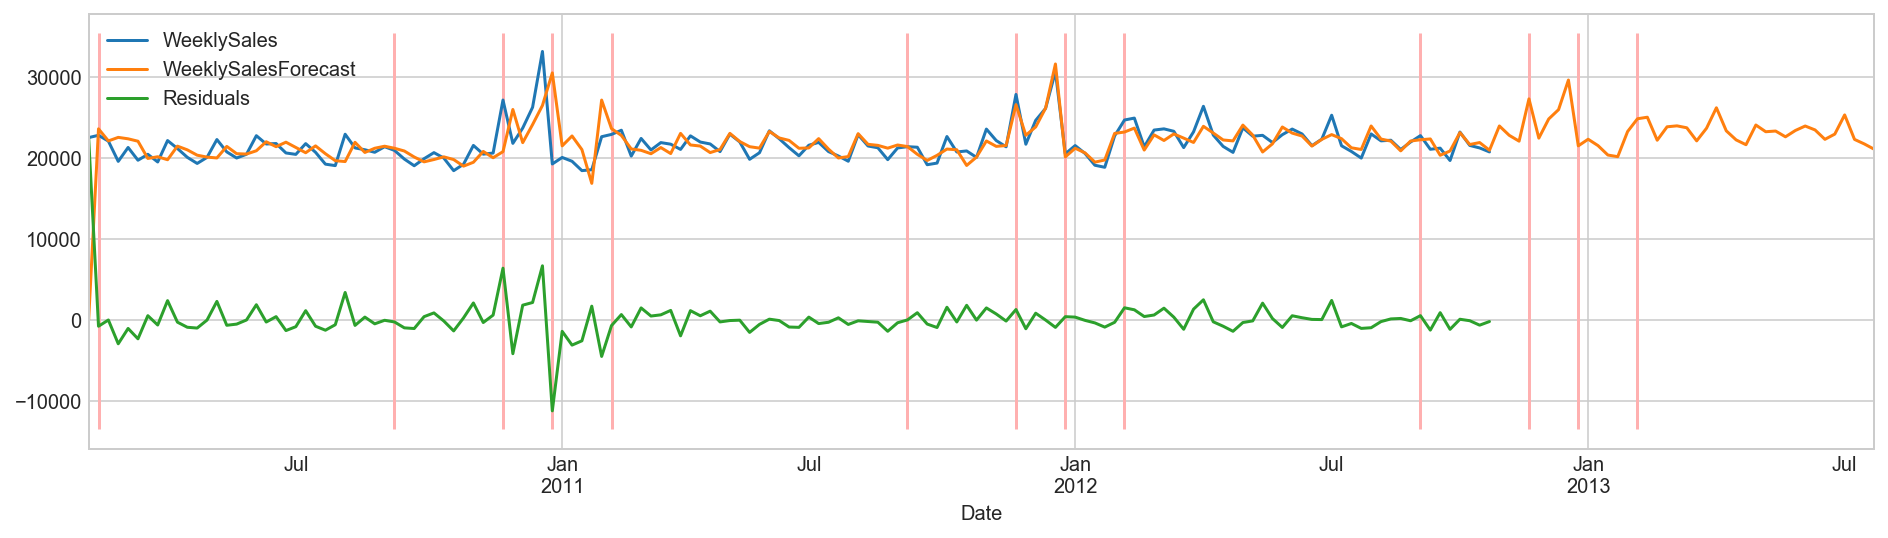

In [7]:
ax = dfa.query('Store==1').plot(x='Date', y=['WeeklySales','WeeklySalesForecast', 'Residuals'], figsize=(16,4))
ymin, ymax = ax.get_ylim()
ax.vlines(x=holidays, ymin=ymin, ymax=ymax-1, color='#ffb0b0')
plt.show()

In [8]:
y_actual = dfa.WeeklySales
y_pred = dfa.WeeklySalesForecast
w = dfa.IsHoliday.map(lambda v: 5 if v else 1).values

rmse = np.sqrt(np.mean((y_pred-y_actual)**2))    
wmae = np.sum(w*(y_pred-y_actual)) / np.sum(w)
mae = np.mean(np.abs(y_pred-y_actual))

print("MAE=%s WMAE=%s RMSE=%s" % (mae, wmae, rmse))

MAE=1063.28099312 WMAE=-48.088433514 RMSE=2461.50480763
